# Common-nearest-neighbour clustering on MD data sets of a small peptide (PDB ID 6a5j)

In [54]:
import pathlib
import warnings

from cnnclustering import cluster, plot
from cnnclustering import _types
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj
import nglview
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import os

In [55]:
mpl.rcParams["figure.dpi"] = 150

## Simulation data

Simulation data:

  - 5 replica à 75.000 frames (750 ns, $dt = 10$ ps)
  - 300 K
    

### (a) Load all the trajectories

In [56]:
cwd = os.getcwd()
ref_pdb = os.path.join(cwd, 'files/6a5j_protein/reference.pdb')

datadir = pathlib.Path("/home/puneek95/nobackup")
trajectory_files = [datadir / f"replica_{i}.dcd" for i in range(1, 6)]     
top_file = ref_pdb

In [57]:
trajectories = mdtraj.load([str(p) for p in trajectory_files], top=str(top_file))
trajectories

<mdtraj.Trajectory with 375000 frames, 260 atoms, 13 residues, and unitcells at 0x7fd350f5b048>

### (b) Fit the 'trajectories' to frame 0 and center coordinates

In [58]:
fit_traj = os.path.join(cwd, 'files/6a5j_protein/fitted_trajectory.dcd')

fitted_trajectories = trajectories.superpose(trajectories, frame=0, 
                                           atom_indices=trajectories.topology.select("protein and backbone")).center_coordinates()
fitted_trajectories.save_dcd(fit_traj)

In [59]:
fitted_trajectories

<mdtraj.Trajectory with 375000 frames, 260 atoms, 13 residues, and unitcells at 0x7fd350f5b048>

### (c) Visualize 'fitted_trajectories' in VMD

In [60]:
view = nglview.show_mdtraj(fitted_trajectories)
view.representations = [
    {
        "type": "cartoon",
        "params": {
            "sele": "protein",
            "color": "sstruc"
        }
    },
    {
        "type": "spacefill",
        "params": {
            "sele": "ion"
        }
    },
    {
        "type": "licorice",
        "params": {
            "sele": "1"
        }
    },
]
view

NGLWidget(max_frame=374999)

## RMSD 

In [61]:
backbone_atoms = trajectories.topology.select("backbone")      # Consider only the backbone atoms
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rmsd = mdtraj.rmsd(trajectories, trajectories, frame=0, atom_indices=backbone_atoms)     

In [62]:
rmsd_path = os.path.join(cwd, 'files/6a5j_protein/rmsd_backbone.npy')
np.save(rmsd_path, rmsd)     # Save the trajectory

In [63]:
rmsd = np.load(rmsd_path)

In [64]:
rmsd.shape

(375000,)

Text(0, 0.5, 'probability density')

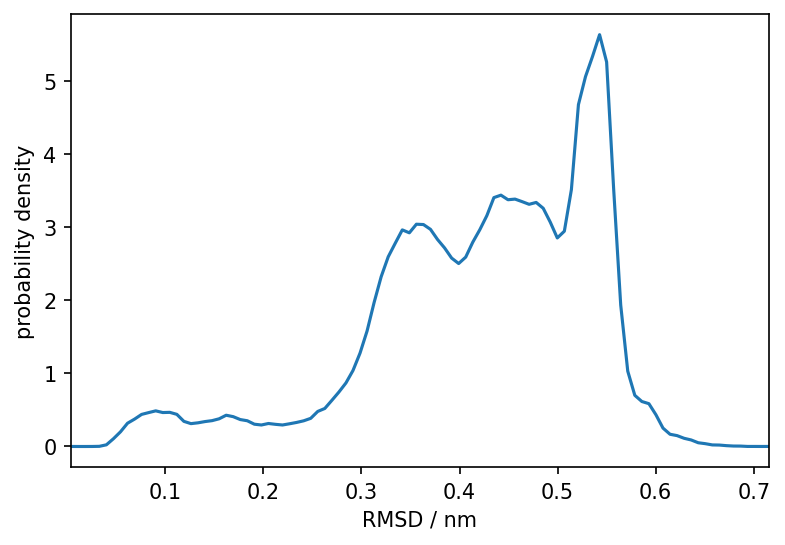

In [65]:
h, e = np.histogram(rmsd, bins=100, density=True)
e = (e[:-1] + e[1:]) / 2
fig, ax = plt.subplots()
ax.plot(e, h)
ax.set_xlim(e[0], e[-1])
ax.set_xlabel("RMSD / nm")
ax.set_ylabel("probability density")

In [66]:
# Striding for faster clustering
rmsd_reduced = rmsd[::10]     # Select only every 10th point in the trajectory

In [67]:
clustering = cluster.prepare_clustering(np.atleast_2d(rmsd_reduced).T)

In [68]:
clustering.input_data.shape

(37500, 1)

In [69]:
# Pre-compute distances for inspection
distances = pairwise_distances(clustering.input_data)
distance_clustering = cluster.prepare_clustering(distances)
distance_clustering._metric = _types.MetricExtPrecomputed()

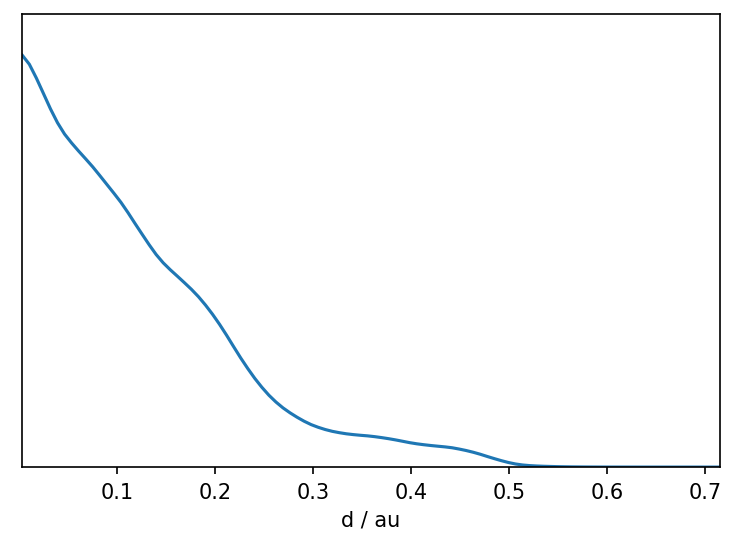

In [70]:
fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances.flatten(), maxima=True, maxima_props={"order": 5})

Cluster parameter scan in which $c$ is kept constant and $r$ is gradually decreased over a meaning full range (start: 1 cluster, end: almost all points noise). Member cutoff to filter out very small clusters.

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.002     10        20        None      1         0.998     0.002     00:00:7.462
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.002     10        20        None      1         0.998     0.002     00:00:7.325
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.001     10        20        None      4         0.93

/home/puneek95/anaconda3/envs/md_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.000     10        20        None      368       0.100     0.423     00:00:9.175
-----------------------------------------------------------------------------------------------



/home/puneek95/anaconda3/envs/md_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


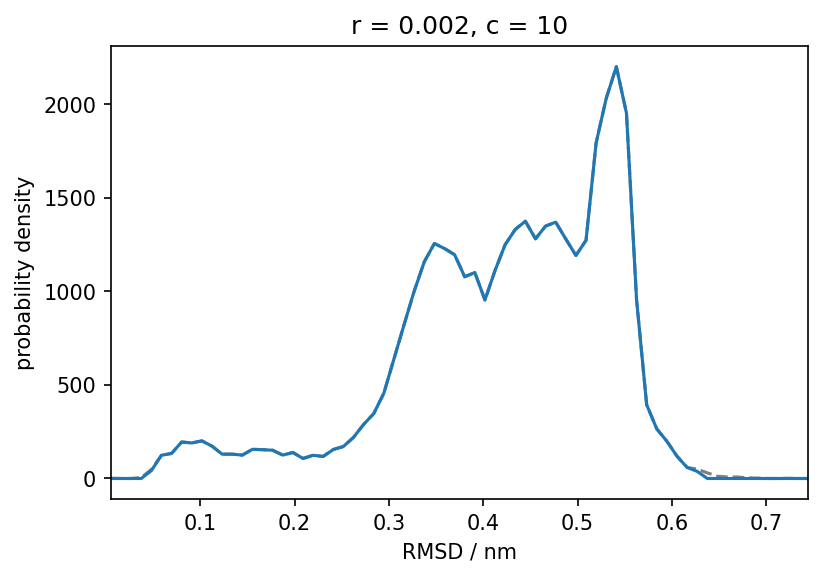

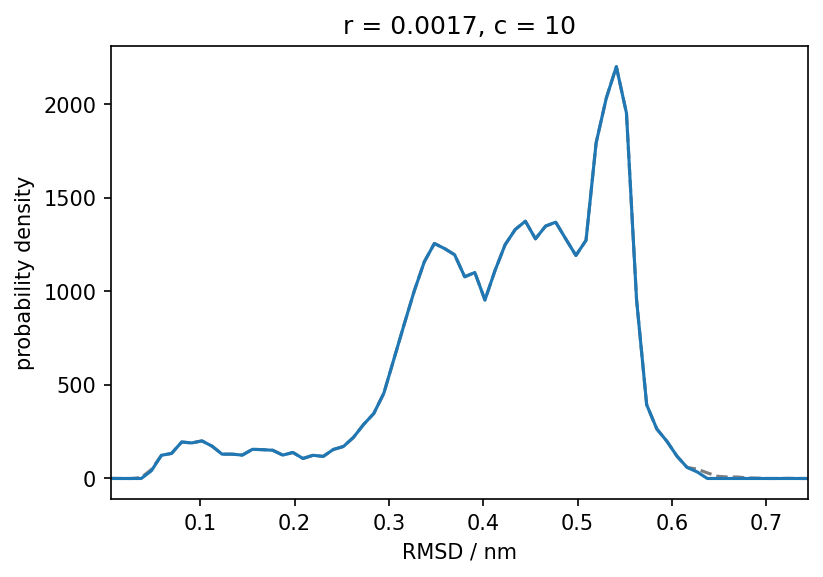

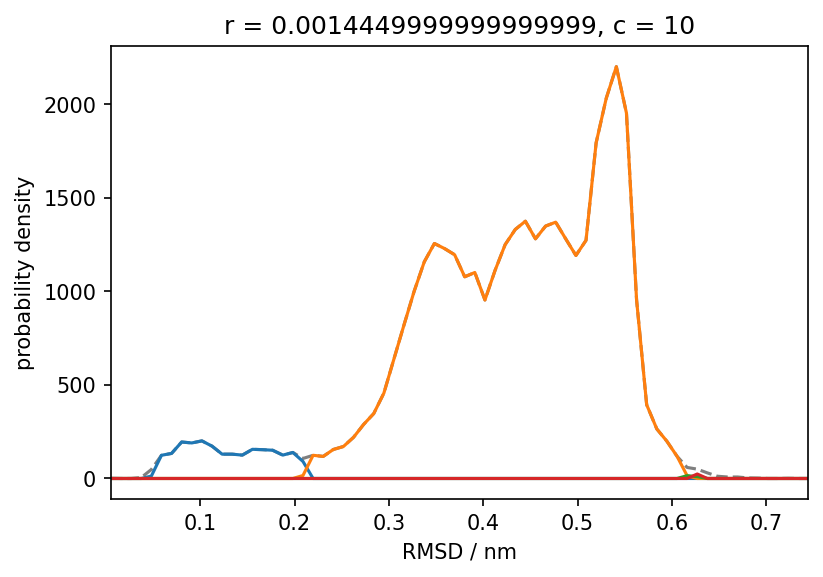

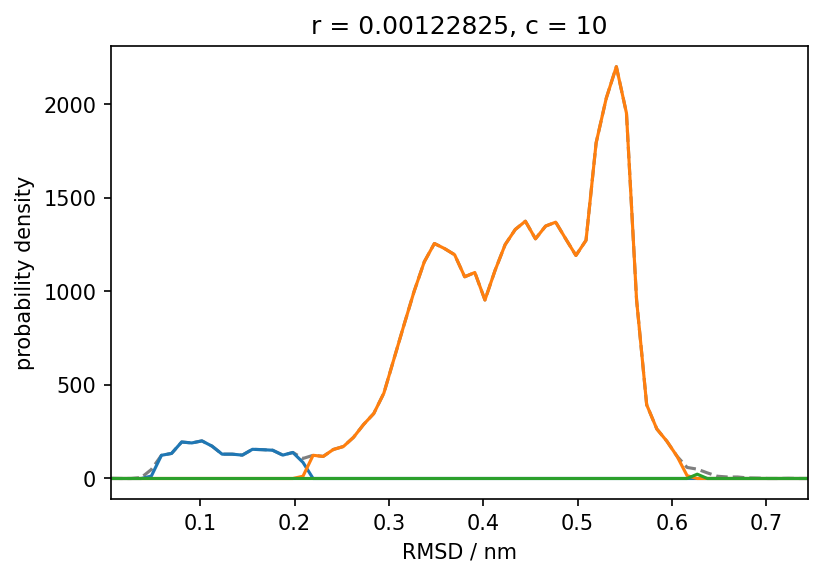

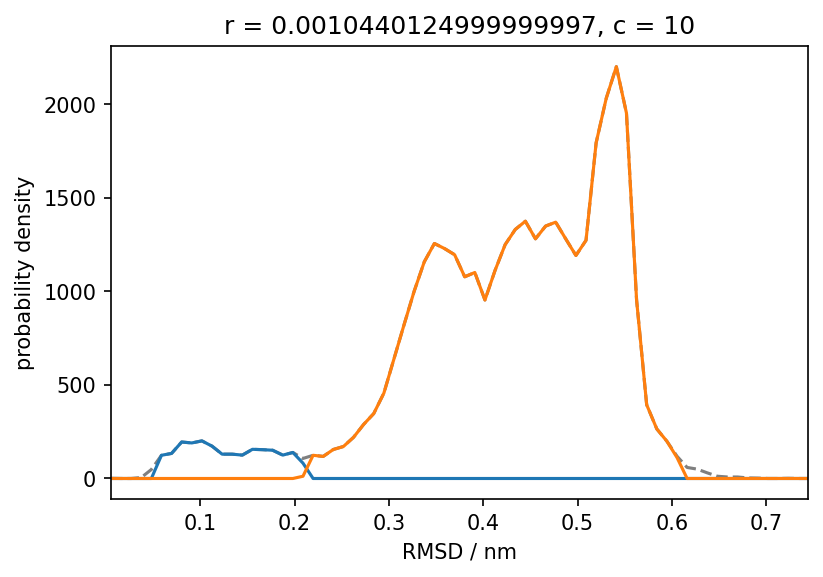

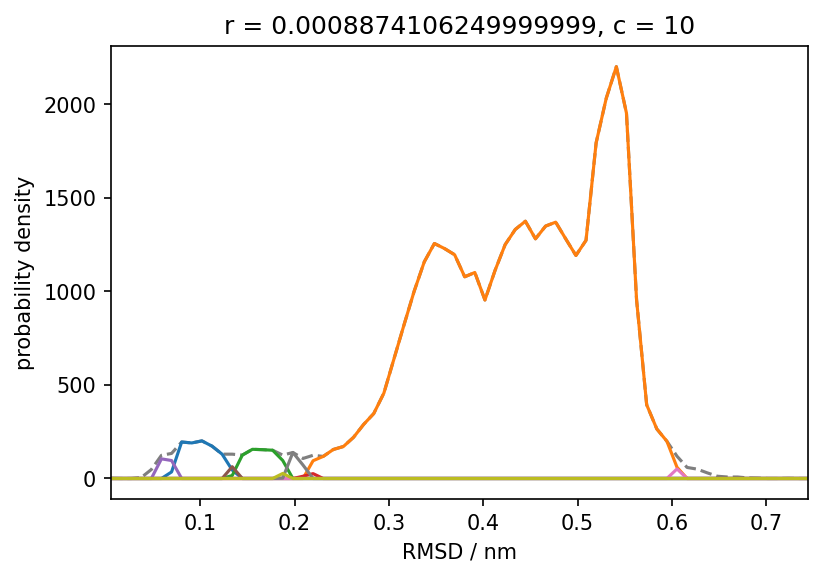

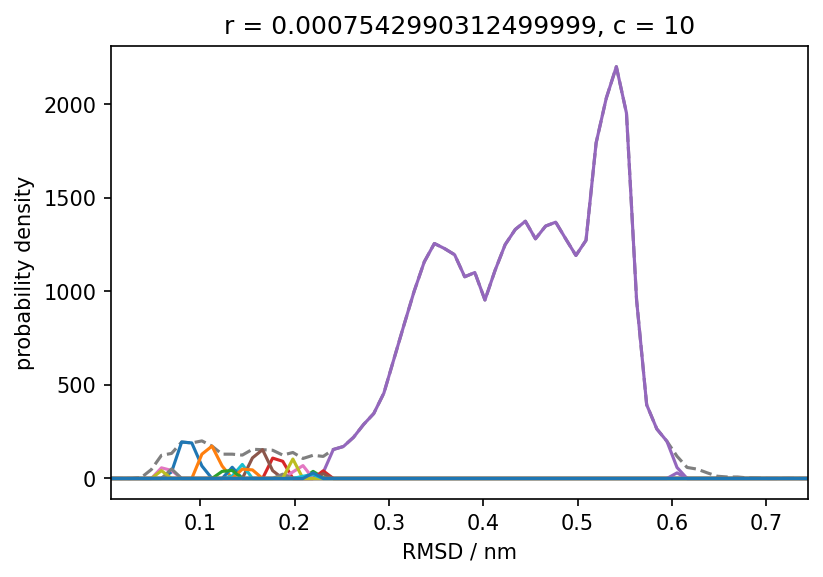

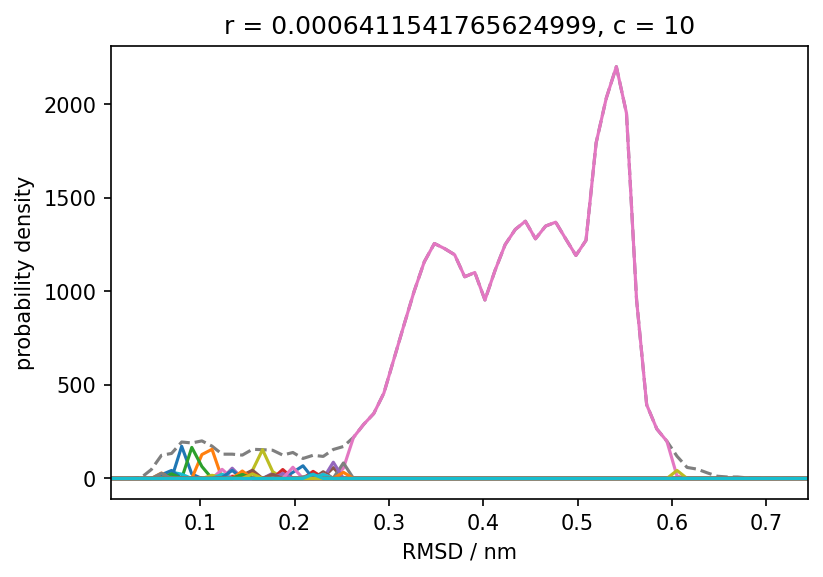

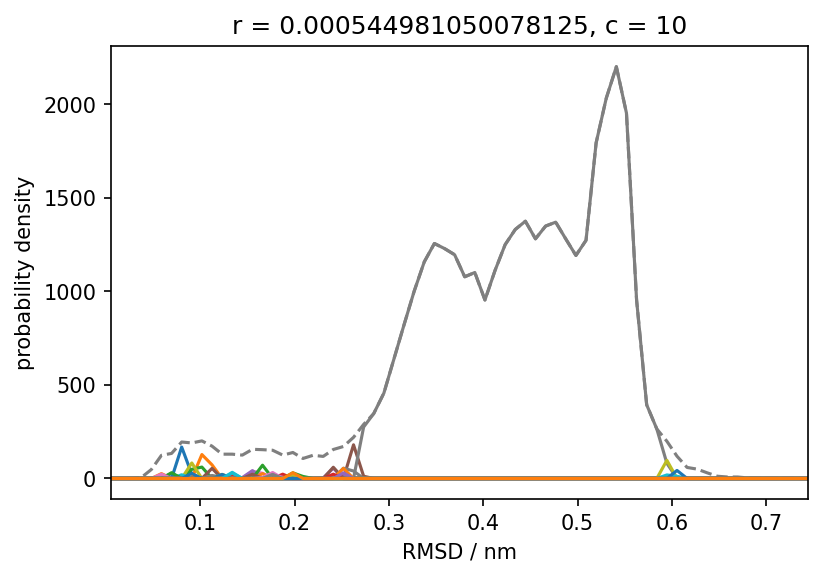

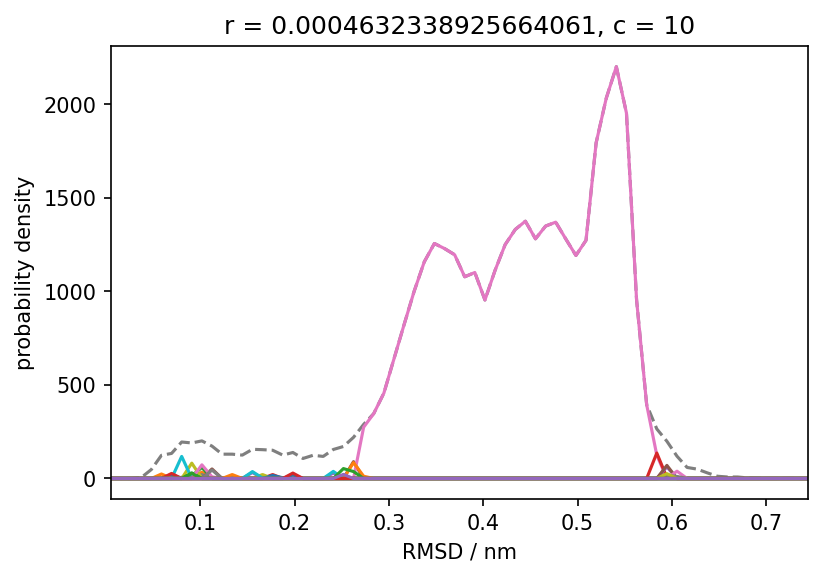

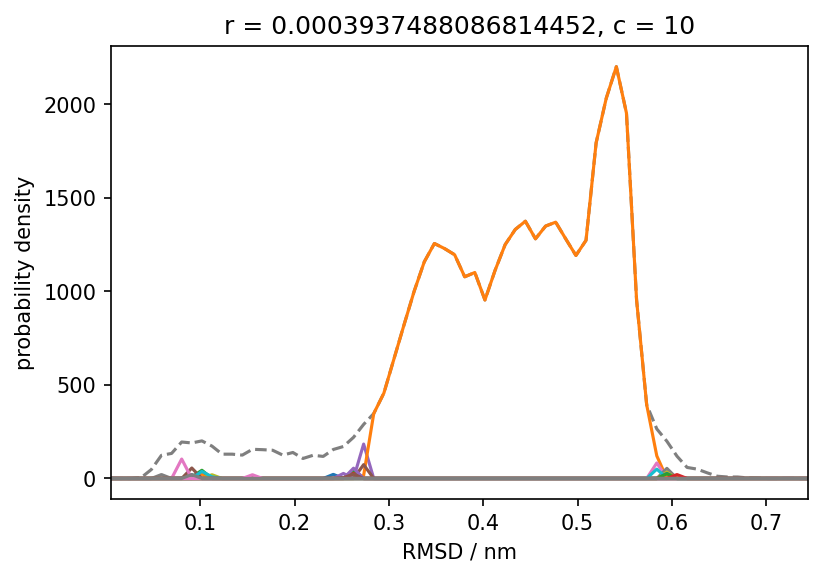

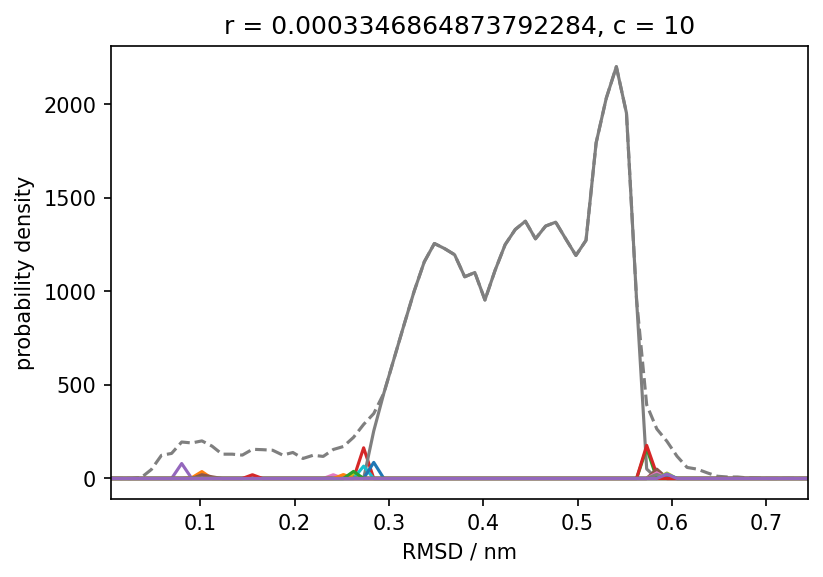

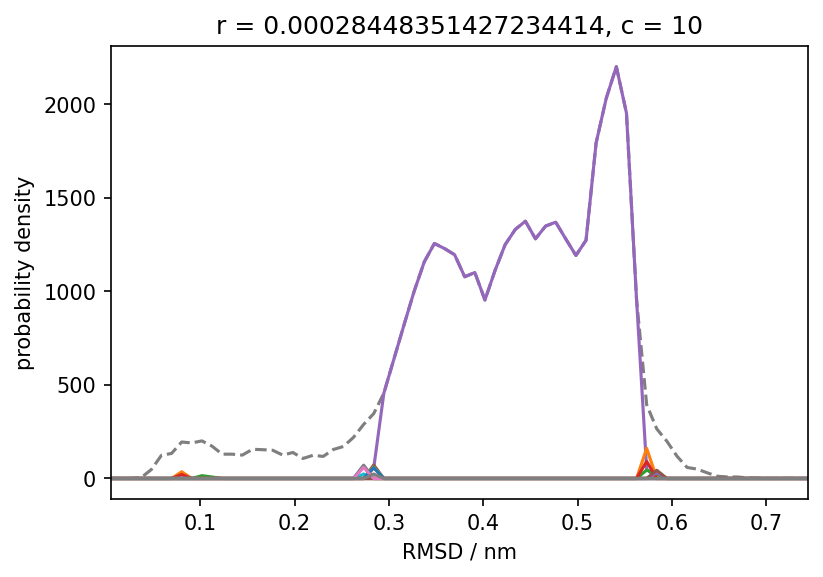

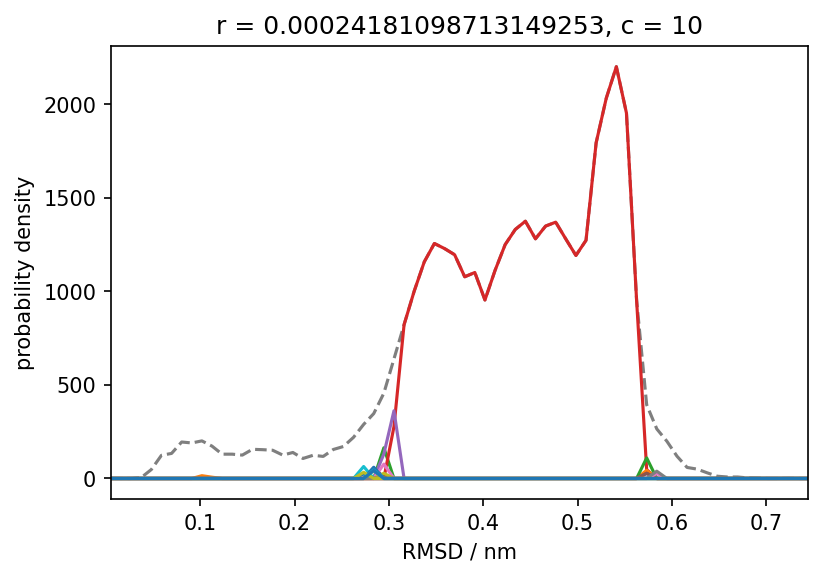

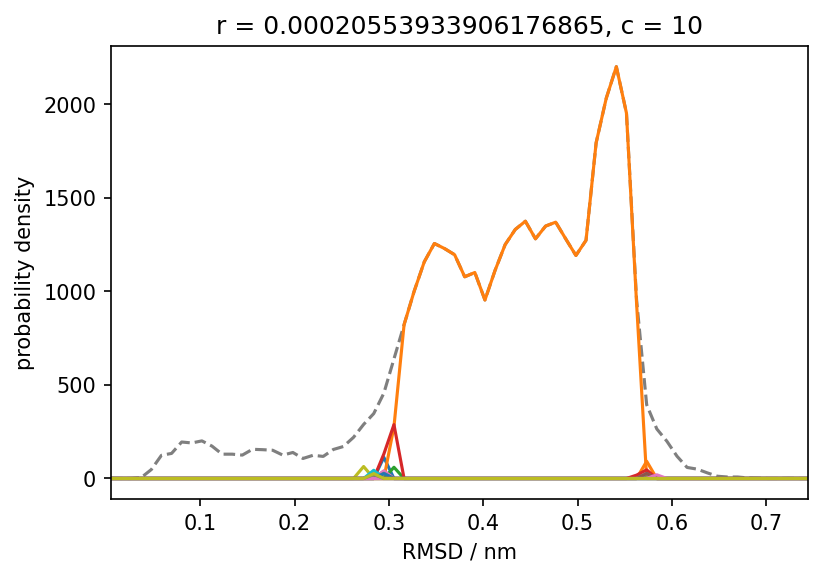

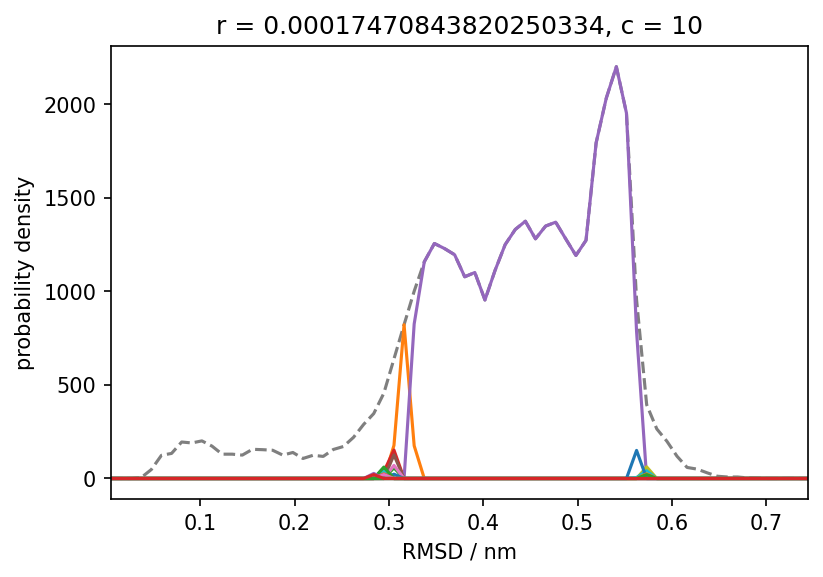

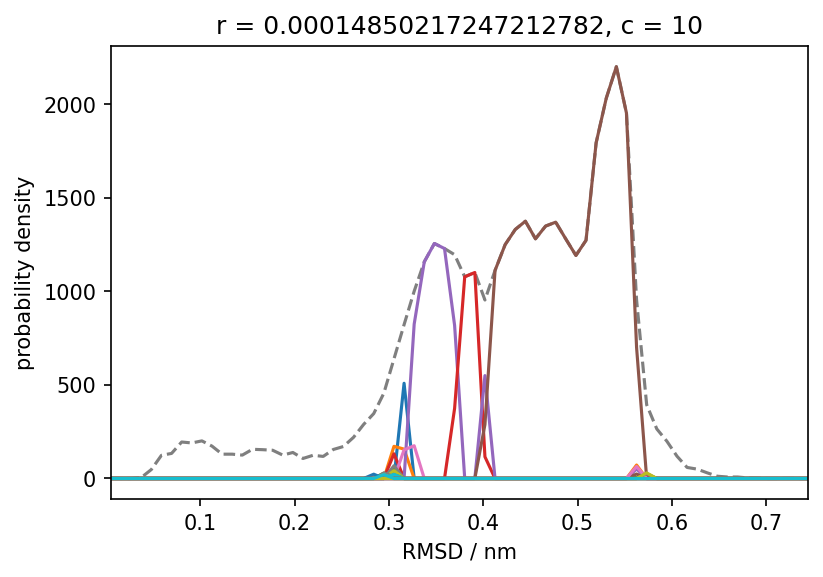

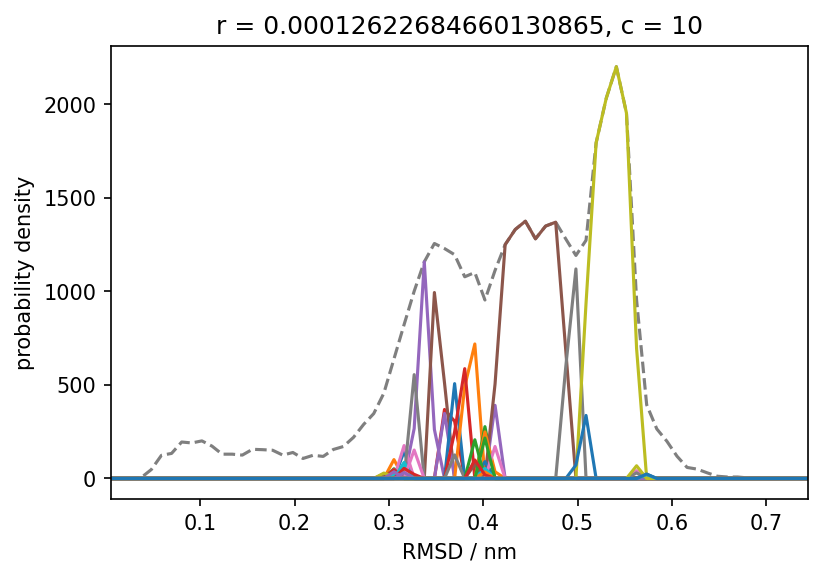

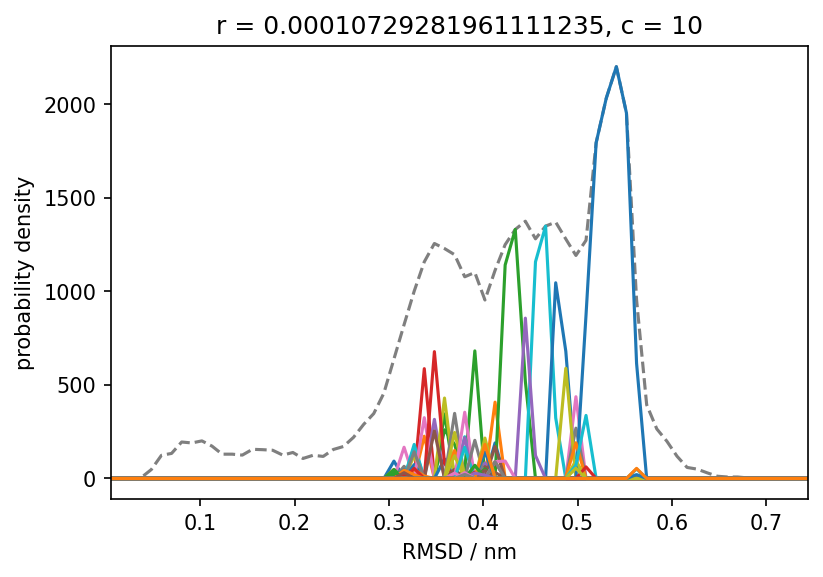

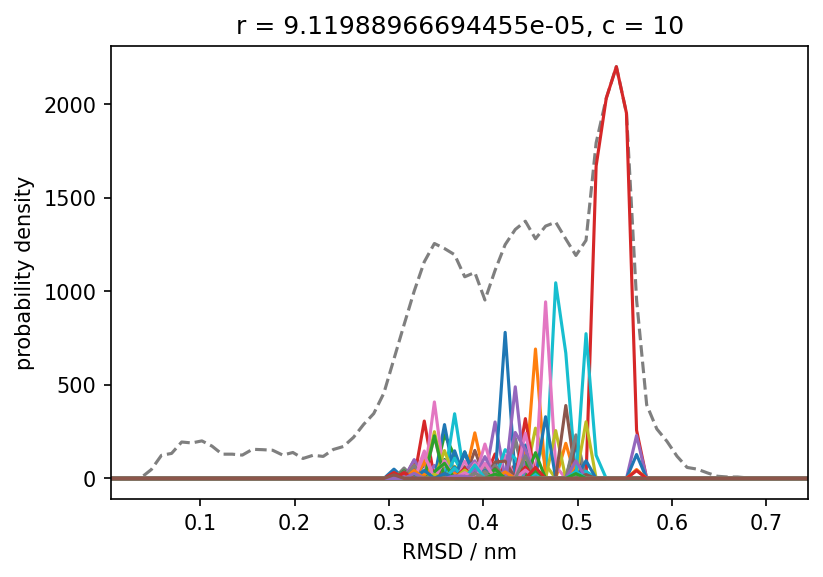

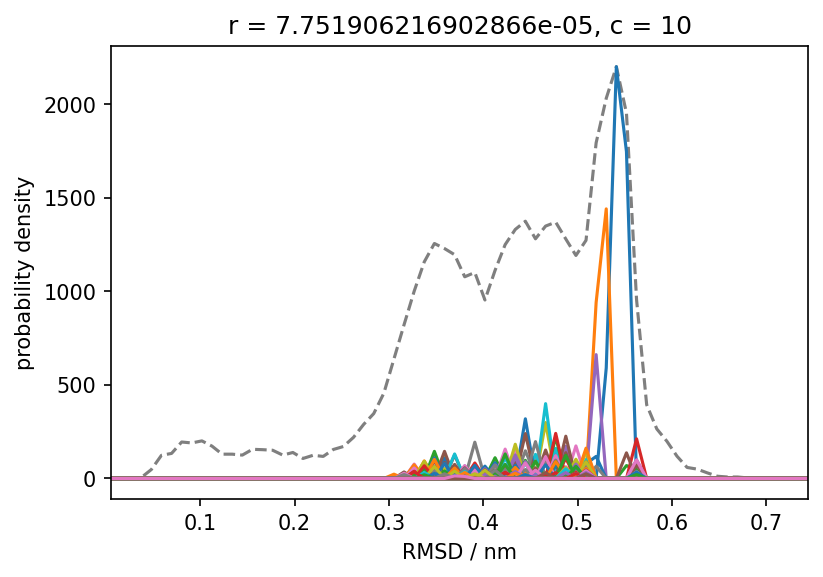

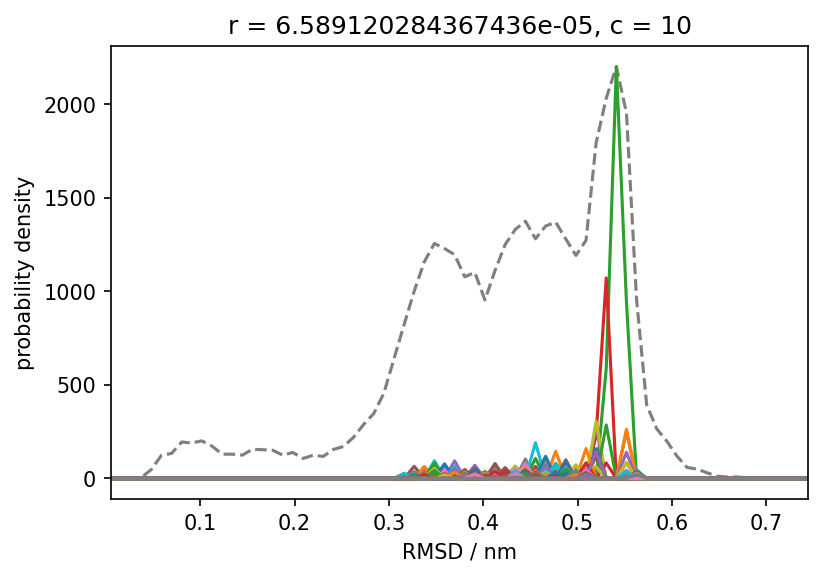

In [71]:
c = 10
for r in [0.002 * 0.85 ** i for i in range(22)]:

    distance_clustering.fit(r, c, member_cutoff=20)

    fig, ax = plt.subplots()

    h, e = np.histogram(rmsd_reduced, bins=70, density=False, range=(0, 0.75))
    e = (e[:-1] + e[1:]) / 2

    ax.plot(e, h, "k--", alpha=0.5)

    for label, indices in distance_clustering.labels.mapping.items():
        if label == 0:
            continue  

        h, e = np.histogram(rmsd_reduced[indices], bins=70, density=False, range=(0, 0.75))
        e = (e[:-1] + e[1:]) / 2

        ax.plot(e, h)
    ax.set_xlim(e[0], e[-1])
    ax.set_xlabel("RMSD / nm")
    ax.set_ylabel("probability density")
    ax.set_title(f"r = {r}, c = {c}")

Similar scan as above but for other values of $c$. Silenced, no plotting, but results are recorded.

In [72]:
for c in [0, 1, 5, 20, 40]: 
    for r in [0.002 * 0.85 ** i for i in range(22)]:

        distance_clustering.fit(r, c, member_cutoff=20, v=False)

### Scan summary

In [73]:
distance_clustering.summary.to_DataFrame()

,n_points,radius_cutoff,cnn_cutoff,member_cutoff,max_clusters,n_clusters,ratio_largest,ratio_noise,execution_time
0,37500,0.002000,10,20,<NA>,1,0.997653,0.002347,7.461895
1,37500,0.001700,10,20,<NA>,1,0.997547,0.002453,7.325407
2,37500,0.001445,10,20,<NA>,4,0.935200,0.004000,7.595164
3,37500,0.001228,10,20,<NA>,3,0.935093,0.004933,7.188862
4,37500,0.001044,10,20,<NA>,2,0.934507,0.006587,7.228816
...,...,...,...,...,...,...,...,...,...
127,37500,0.000126,40,20,<NA>,54,0.010773,0.847387,10.815188
128,37500,0.000107,40,20,<NA>,53,0.003253,0.927227,7.705195
129,37500,0.000091,40,20,<NA>,16,0.001627,0.983627,4.910251
130,37500,0.000078,40,20,<NA>,3,0.000827,0.998027,3.594795


(6.589120284367436e-05, 0.00075)

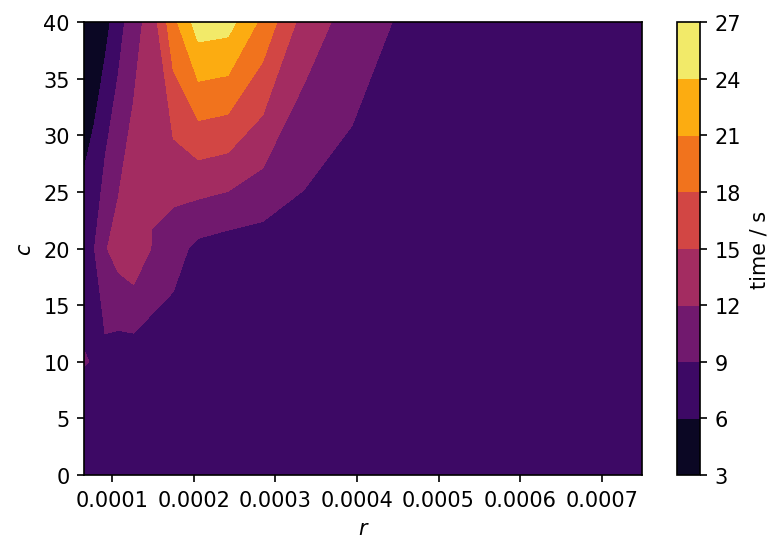

In [74]:
# Computing time
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="execution_time")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax)
colorbar.set_label("time / s")
ax.set_xlim(None, 0.00075)

(6.589120284367436e-05, 0.00075)

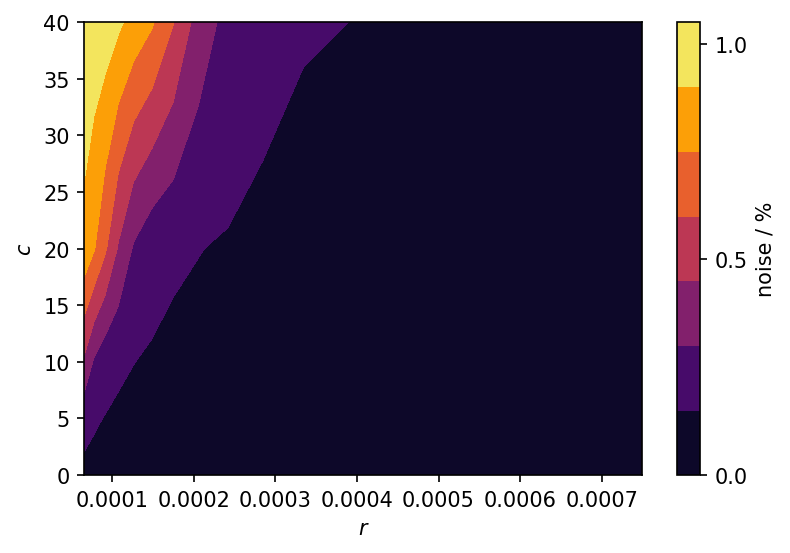

In [75]:
# Noise level
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="ratio_noise")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("noise / %")
ax.set_xlim(None, 0.00075)

(6.589120284367436e-05, 0.00075)

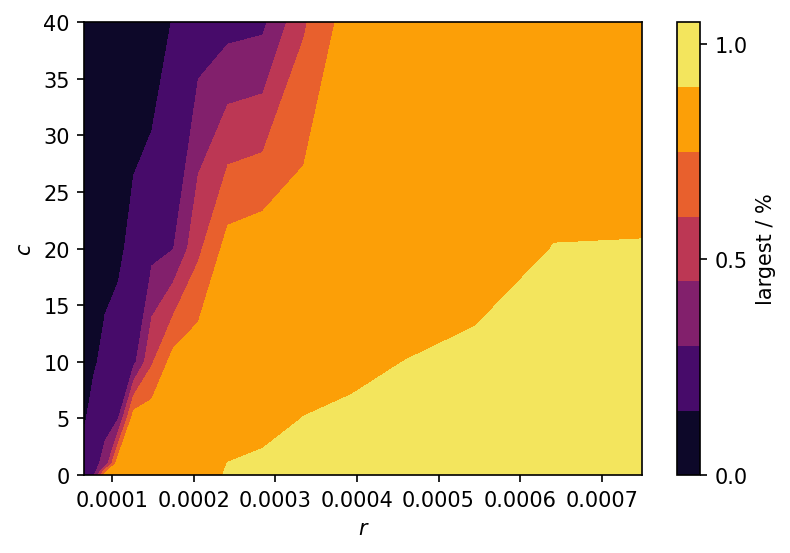

In [76]:
# Largest cluster
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="ratio_largest")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("largest / %")
ax.set_xlim(None, 0.00075)

(6.589120284367436e-05, 0.00075)

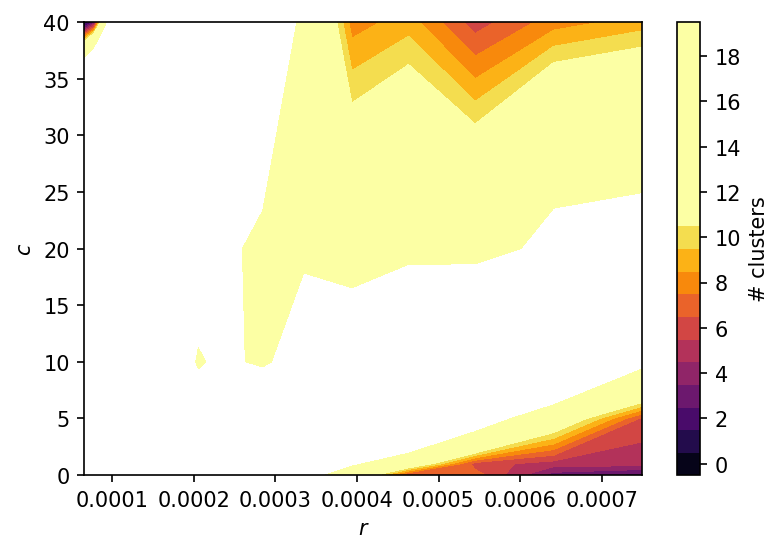

In [77]:
# Largest cluster
show_n = 20

fig, ax = plt.subplots()
contour = distance_clustering.summarize(
    ax=ax,
    quantity="n_clusters",
    contour_props={"levels": np.arange(-0.5, show_n, 1),
               "vmax": 11}
)[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=range(0, show_n + 1, 2))
colorbar.set_label("# clusters")
ax.set_xlim(None, 0.00075)

# PCA

In [78]:
pca = PCA(n_components=2)    
fitted_trajectories.xyz.shape

(375000, 260, 3)

In [79]:
pca_input = fitted_trajectories.xyz.reshape(fitted_trajectories.n_frames, fitted_trajectories.n_atoms * 3)
pca_input.shape

(375000, 780)

In [80]:
trajectory_pca = pca.fit_transform(pca_input)
trajectory_pca.shape

(375000, 2)

In [81]:
pca_path = os.path.join(cwd, 'files/6a5j_protein/pca.npy')
np.save(pca_path, trajectory_pca)     # Save the trajectory

In [82]:
pca_traj = np.load(pca_path)

In [83]:
pca_traj.shape

(375000, 2)

In [84]:
pca_clustering = cluster.prepare_clustering(trajectory_pca)

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd350c8d518>)

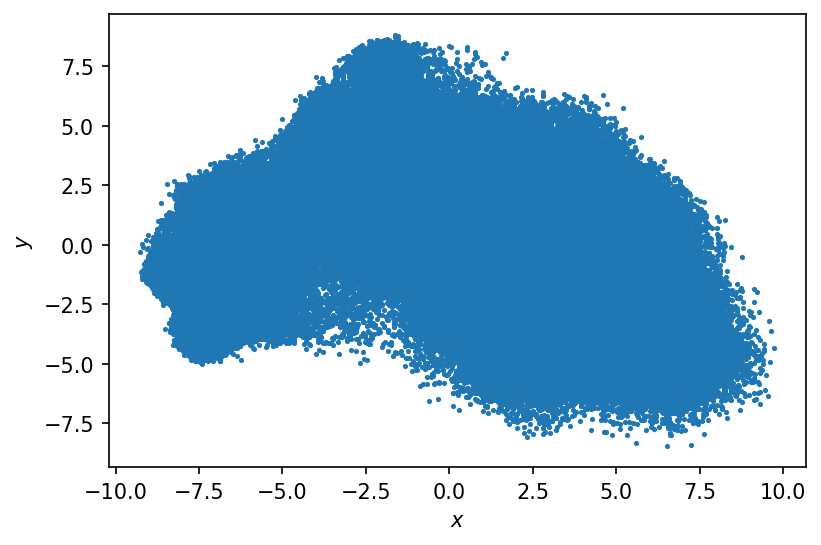

In [85]:
pca_clustering.evaluate()

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd350d30f98>)

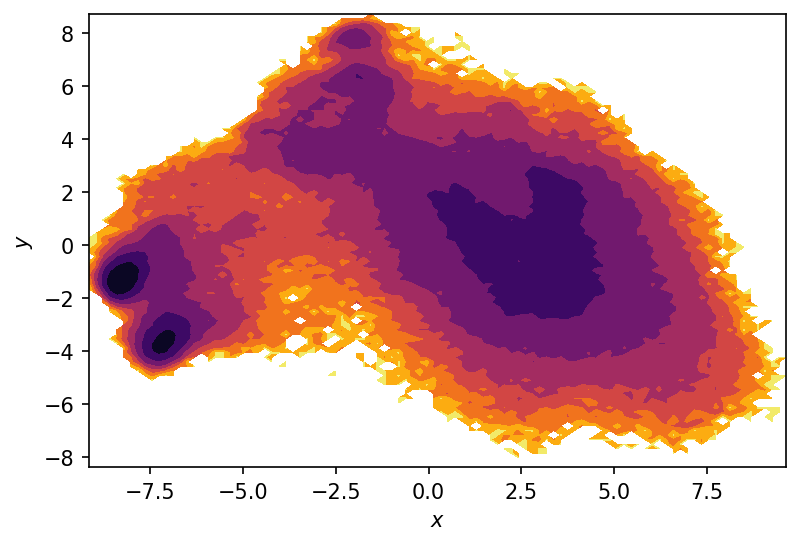

In [86]:
pca_clustering.evaluate(plot_style="contourf")

In [87]:
pca_reduced = pca_traj[::10]     # Consider every 10th point 
pca_reduced.shape

(37500, 2)

In [88]:
pca_clus = cluster.prepare_clustering(pca_reduced)

In [89]:
# Pre-compute distances for inspection
distances = pairwise_distances(pca_clus.input_data)
distance_clustering = cluster.prepare_clustering(distances)
distance_clustering._metric = _types.MetricExtPrecomputed()

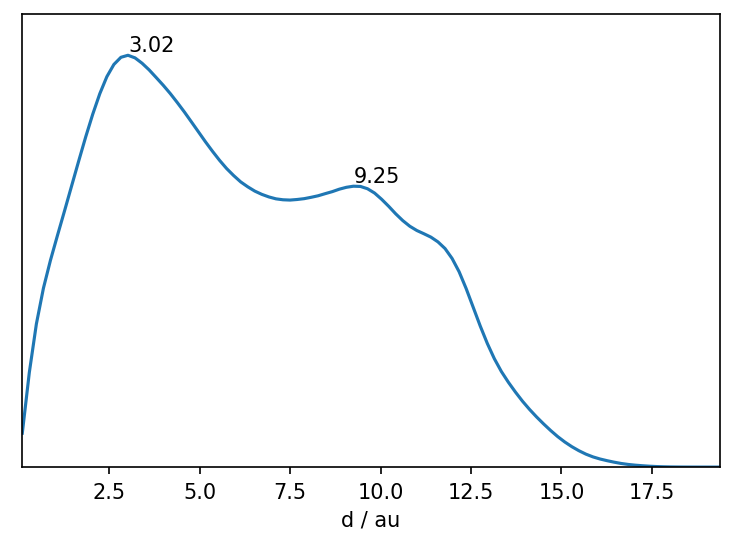

In [90]:
fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances.flatten(), maxima=True, maxima_props={"order": 5})

**Goal**: start: 1 cluster, end: almost all points noise. Member cutoff to filter out very small clusters.

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     1.100     10        20        None      1         1.000     0.000     00:00:8.706
-----------------------------------------------------------------------------------------------



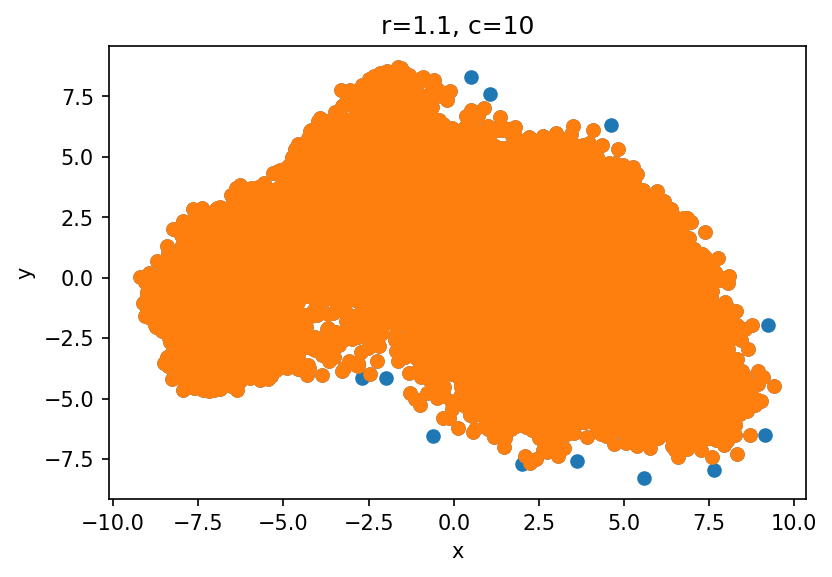

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     1.000     10        20        None      1         1.000     0.000     00:00:8.352
-----------------------------------------------------------------------------------------------



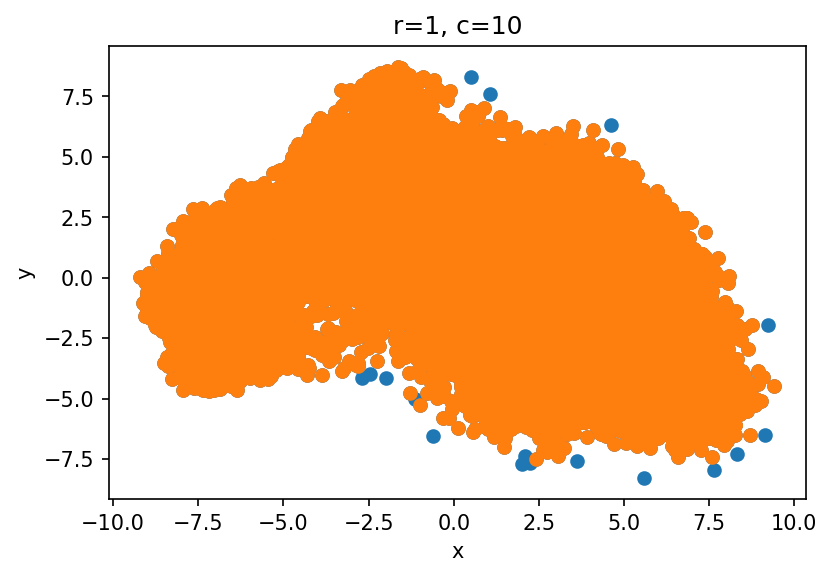

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.900     10        20        None      1         0.999     0.001     00:00:8.531
-----------------------------------------------------------------------------------------------



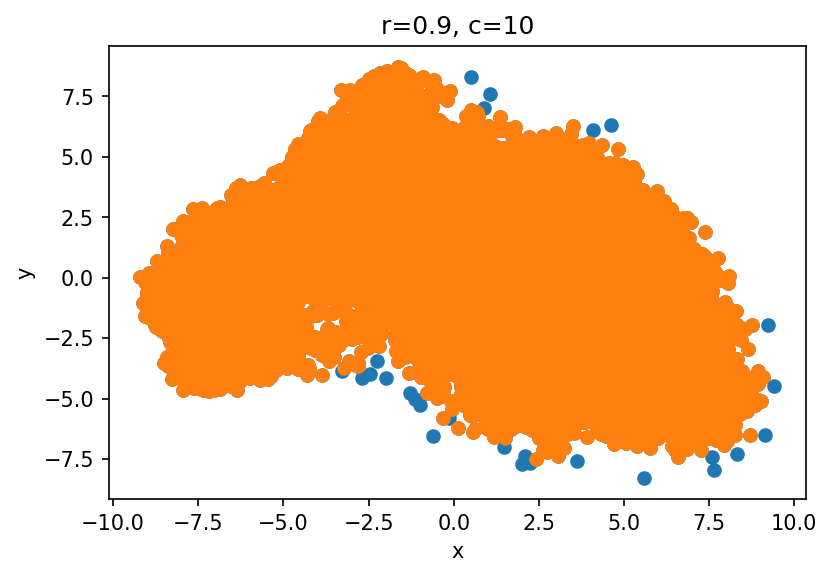

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.800     10        20        None      1         0.999     0.001     00:00:8.147
-----------------------------------------------------------------------------------------------



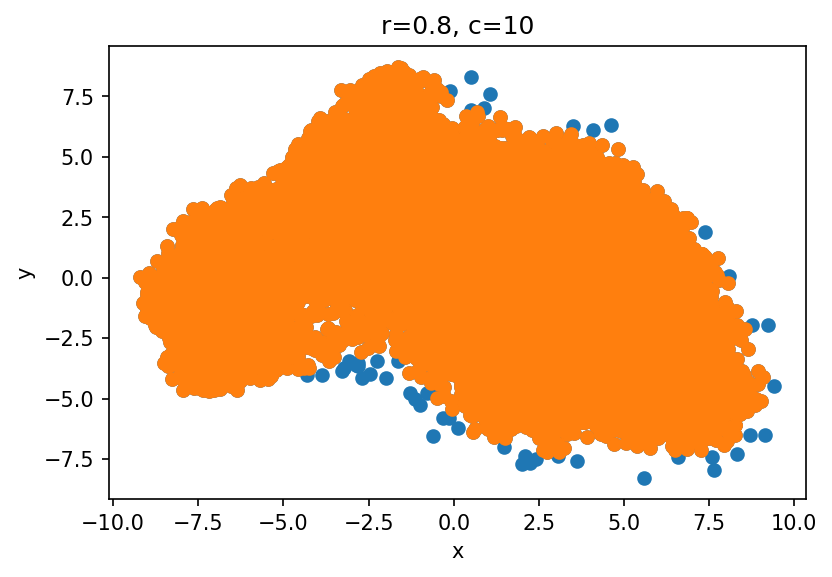

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.700     10        20        None      1         0.998     0.002     00:00:7.675
-----------------------------------------------------------------------------------------------



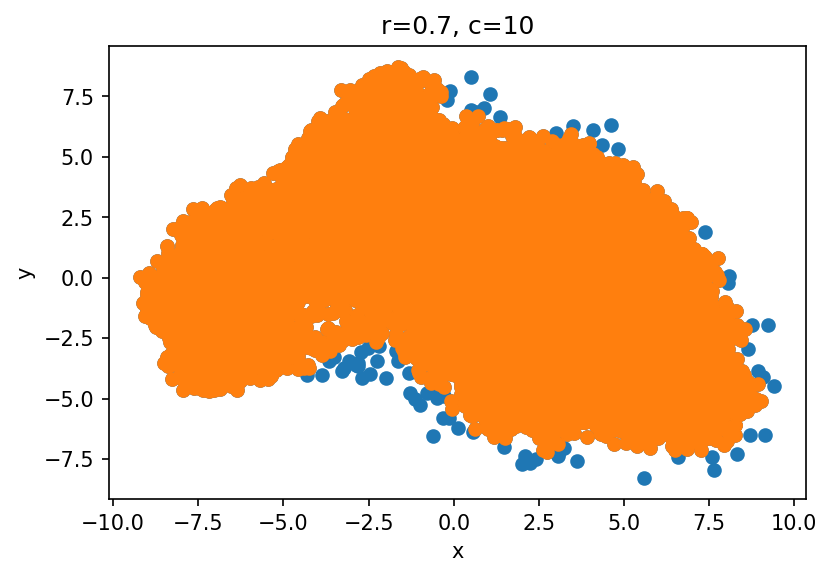

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.600     10        20        None      1         0.996     0.004     00:00:7.987
-----------------------------------------------------------------------------------------------



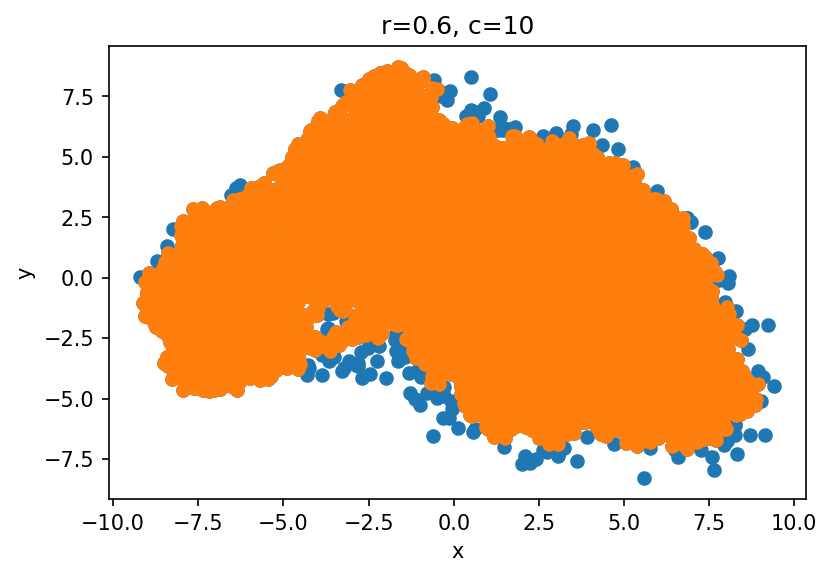

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.500     10        20        None      1         0.993     0.007     00:00:7.496
-----------------------------------------------------------------------------------------------



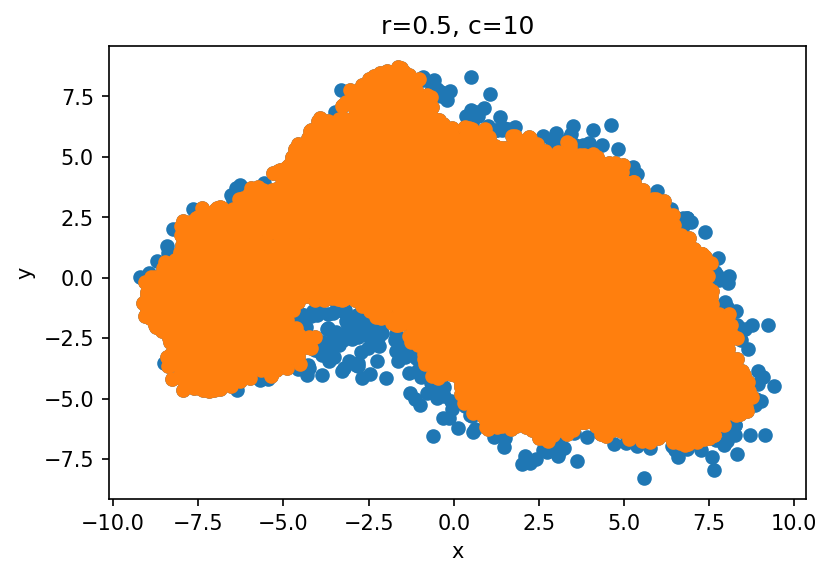

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.400     10        20        None      1         0.987     0.013     00:00:7.252
-----------------------------------------------------------------------------------------------



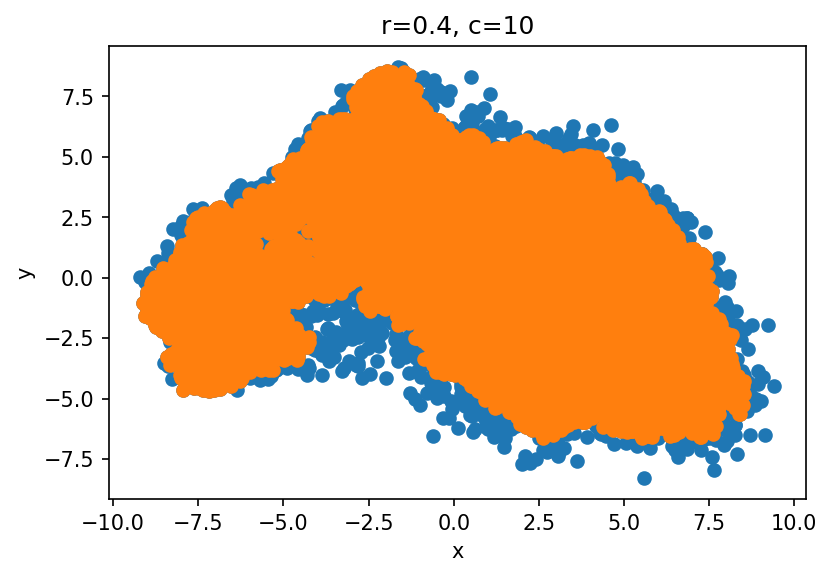

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.300     10        20        None      7         0.760     0.035     00:00:7.846
-----------------------------------------------------------------------------------------------



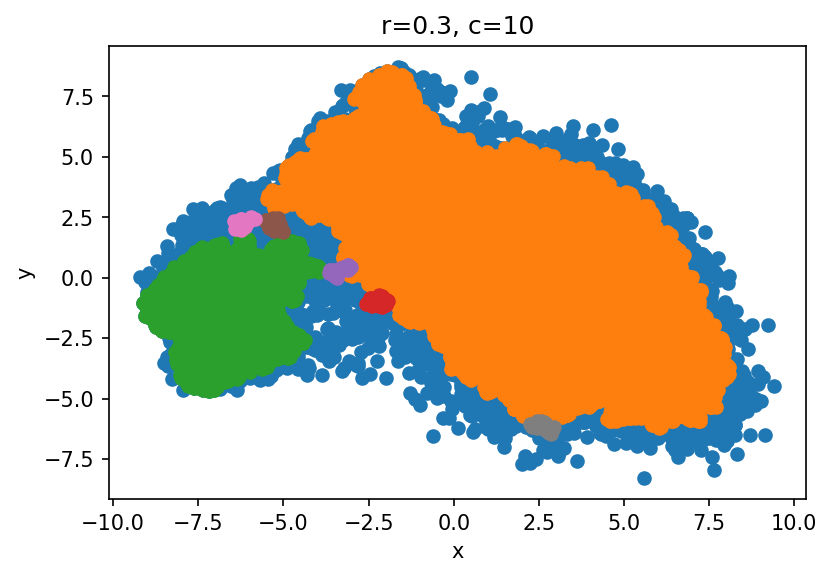

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.200     10        20        None      9         0.692     0.112     00:00:7.937
-----------------------------------------------------------------------------------------------



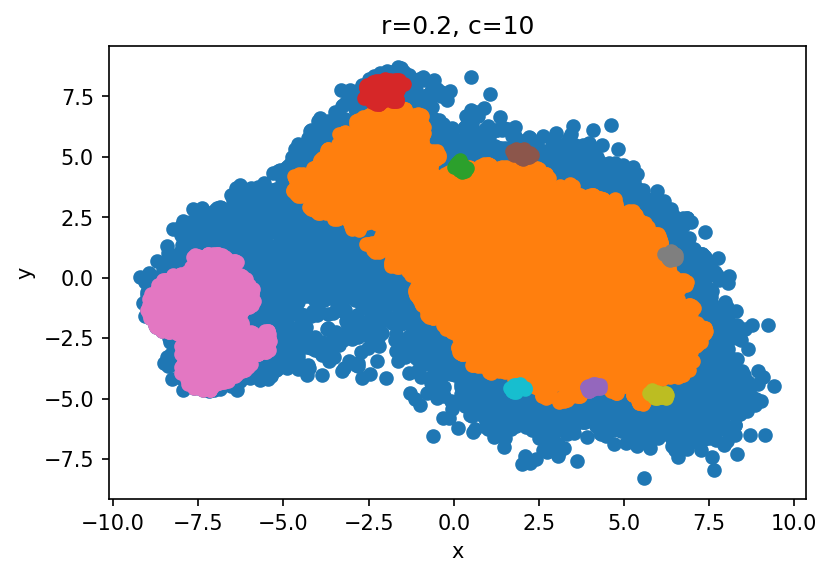

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.100     10        20        None      57        0.259     0.555     00:00:9.007
-----------------------------------------------------------------------------------------------



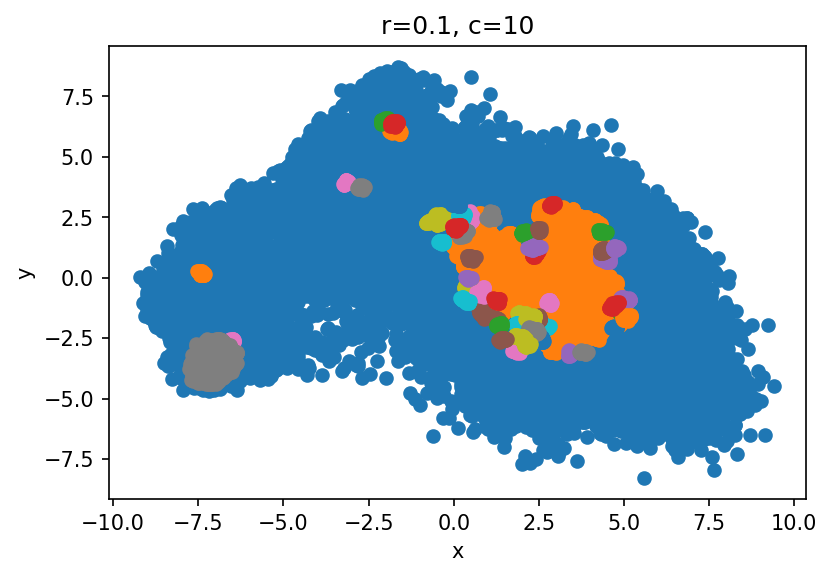

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.090     10        20        None      69        0.088     0.666     00:00:8.444
-----------------------------------------------------------------------------------------------



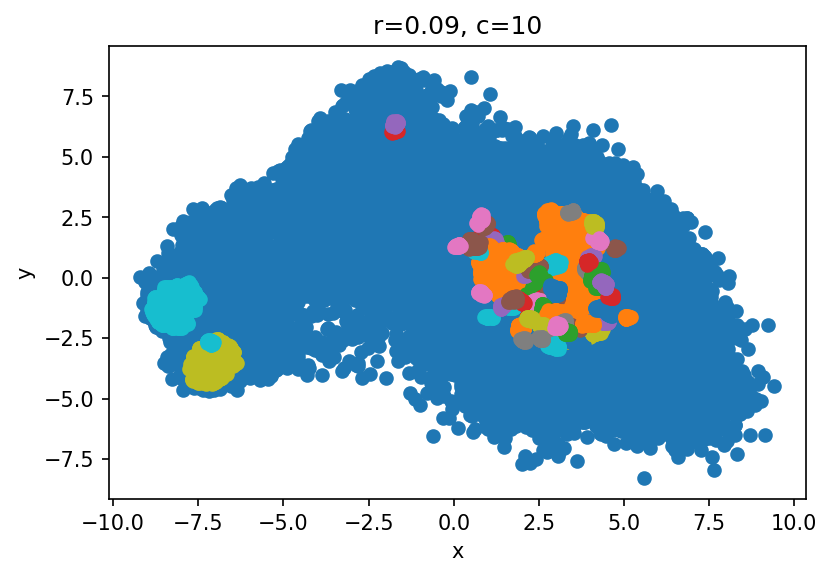

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.080     10        20        None      62        0.072     0.787     00:00:7.227
-----------------------------------------------------------------------------------------------



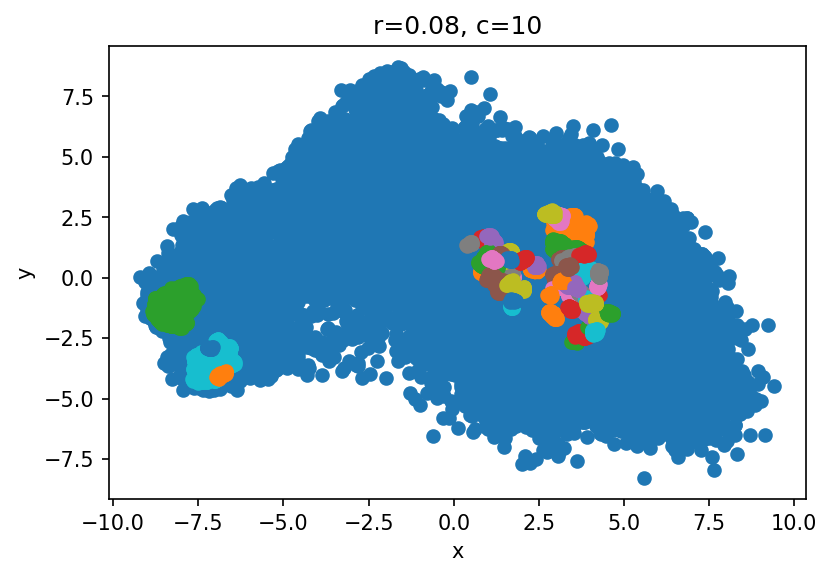

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.070     10        20        None      26        0.065     0.874     00:00:5.872
-----------------------------------------------------------------------------------------------



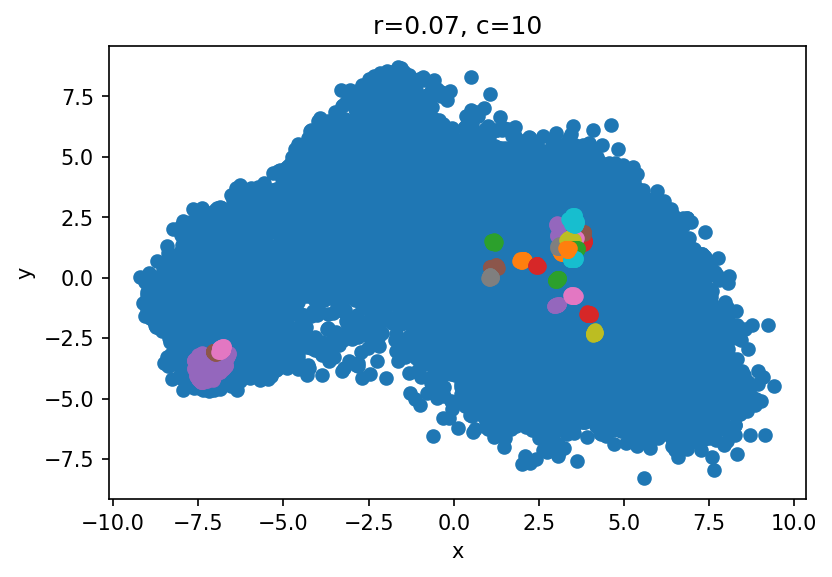

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.060     10        20        None      15        0.055     0.914     00:00:4.949
-----------------------------------------------------------------------------------------------



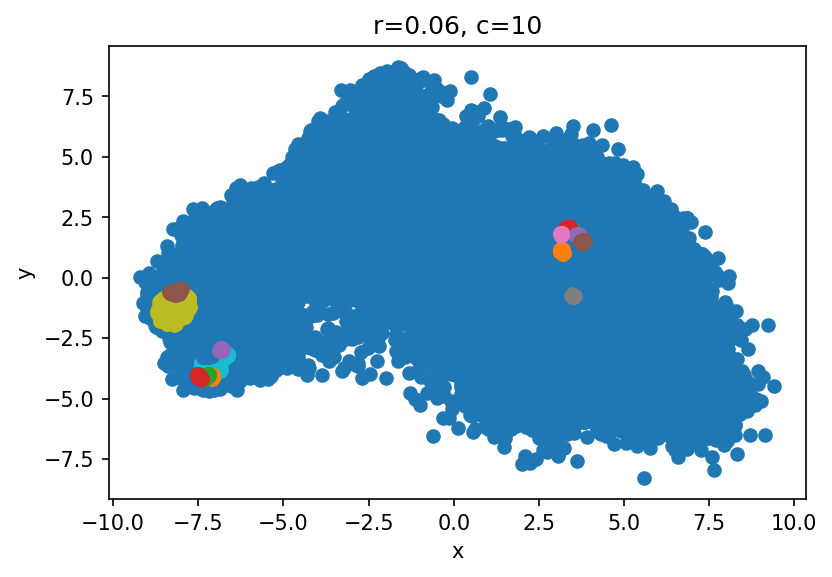

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.050     10        20        None      16        0.040     0.946     00:00:4.129
-----------------------------------------------------------------------------------------------



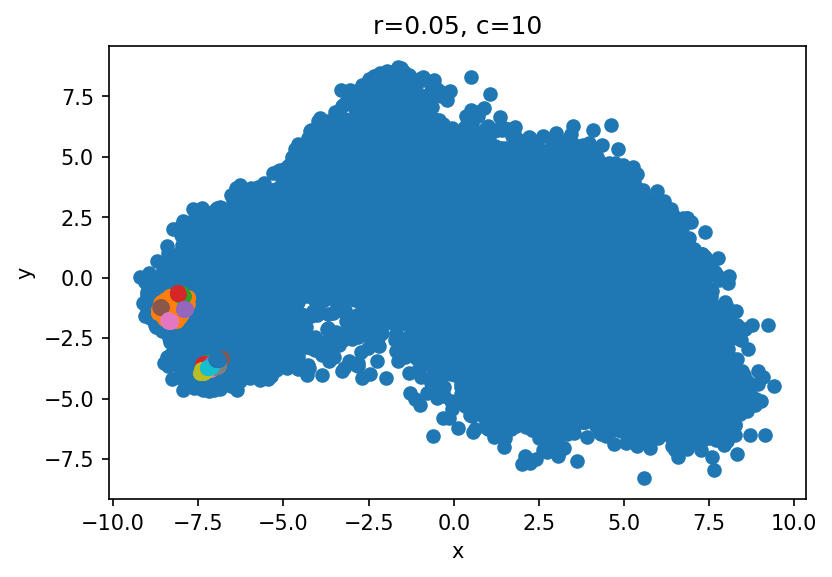

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.040     10        20        None      10        0.009     0.980     00:00:3.951
-----------------------------------------------------------------------------------------------



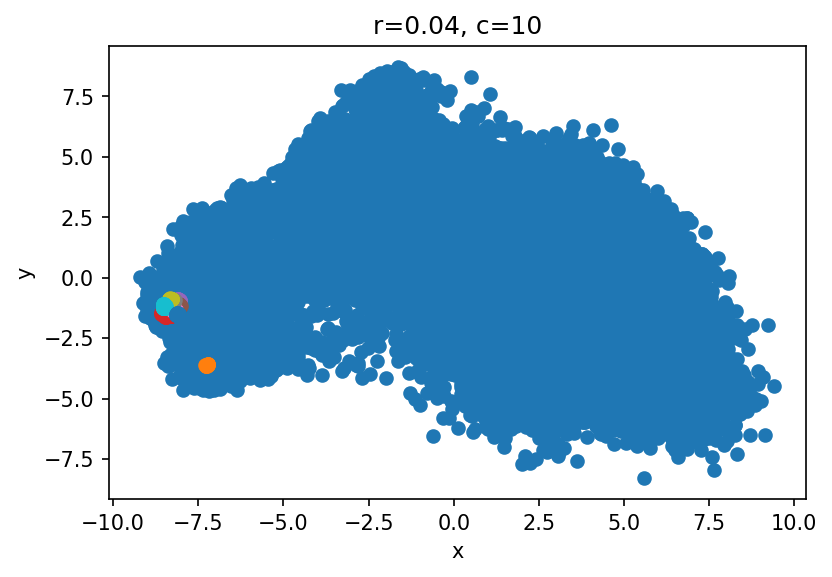

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.030     10        20        None      0         0.000     1.000     00:00:3.409
-----------------------------------------------------------------------------------------------



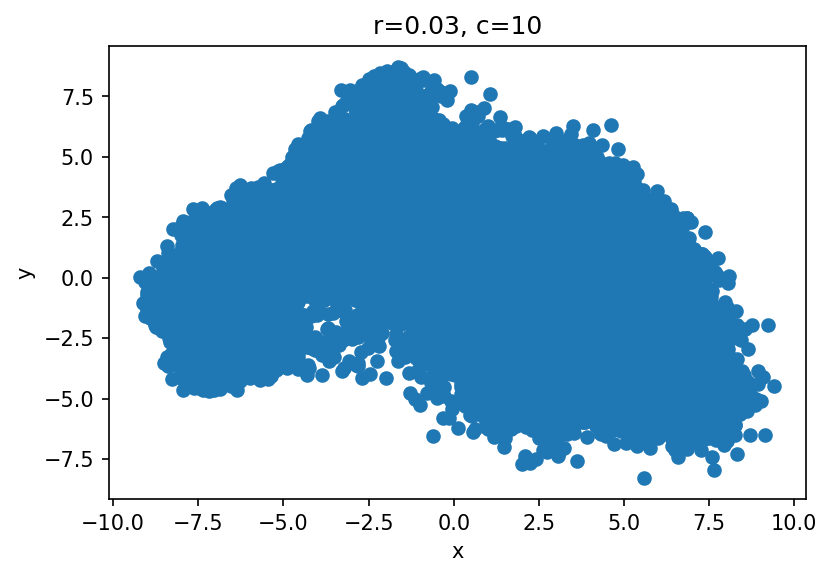

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.020     10        20        None      0         0.000     1.000     00:00:3.598
-----------------------------------------------------------------------------------------------



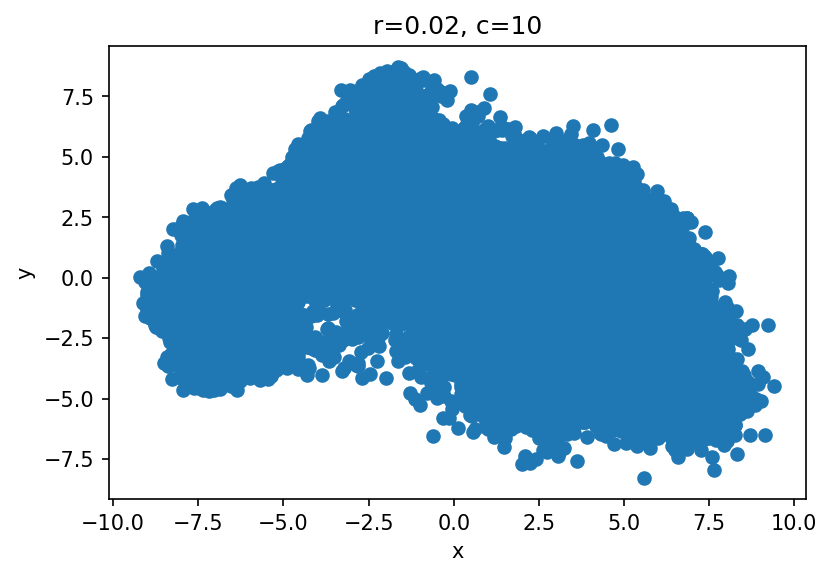

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.010     10        20        None      0         0.000     1.000     00:00:3.417
-----------------------------------------------------------------------------------------------



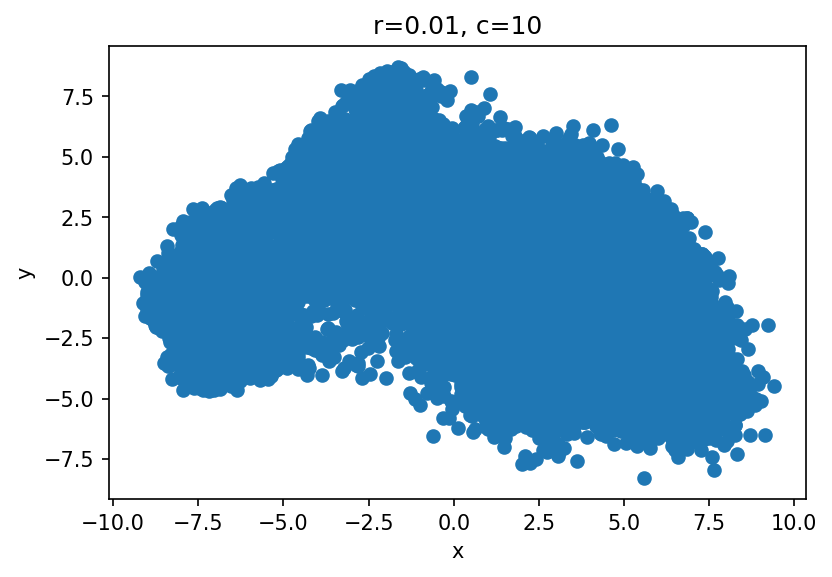

In [91]:
c = 10

for r in [1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]:
    
    distance_clustering.fit(r, c, member_cutoff=20)
    
    plt.figure()
    plt.scatter(pca_reduced[:,0], pca_reduced[:,1])
    
    for label, indices in distance_clustering.labels.mapping.items():
        if label == 0:
            continue
        
        pca_clusters = pca_reduced[indices]
        plt.scatter(pca_clusters[:,0], pca_clusters[:,1])
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'r={r}, c={c}')
    plt.show()

In [92]:
for n_cut in [0, 1, 5, 10, 20, 40]:
    for r_cut in [1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]:
        distance_clustering.fit(r_cut, n_cut, member_cutoff=20, v=False)

In [93]:
distance_clustering.summary.to_DataFrame()

,n_points,radius_cutoff,cnn_cutoff,member_cutoff,max_clusters,n_clusters,ratio_largest,ratio_noise,execution_time
0,37500,1.10,10,20,<NA>,1,0.999680,0.000320,8.705993
1,37500,1.00,10,20,<NA>,1,0.999547,0.000453,8.352032
2,37500,0.90,10,20,<NA>,1,0.999280,0.000720,8.531391
3,37500,0.80,10,20,<NA>,1,0.998693,0.001307,8.147218
4,37500,0.70,10,20,<NA>,1,0.998107,0.001893,7.675052
...,...,...,...,...,...,...,...,...,...
135,37500,0.05,40,20,<NA>,0,0.000000,1.000000,3.590939
136,37500,0.04,40,20,<NA>,0,0.000000,1.000000,3.362002
137,37500,0.03,40,20,<NA>,0,0.000000,1.000000,3.323361
138,37500,0.02,40,20,<NA>,0,0.000000,1.000000,3.458680


(0.01, 1.1)

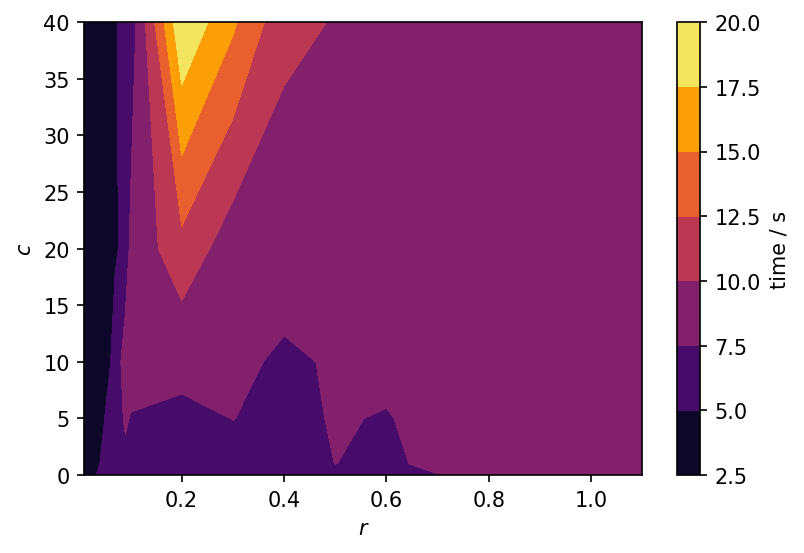

In [94]:
# Computing time
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="execution_time")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax)
colorbar.set_label("time / s")
ax.set_xlim(None, 1.1)

(0.01, 1.1)

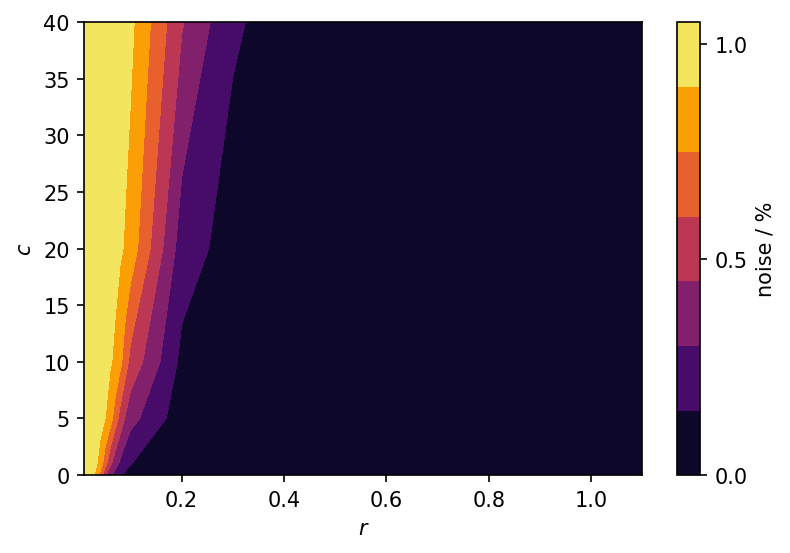

In [95]:
# Noise level
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="ratio_noise")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("noise / %")
ax.set_xlim(None, 1.1)

(0.01, 1.1)

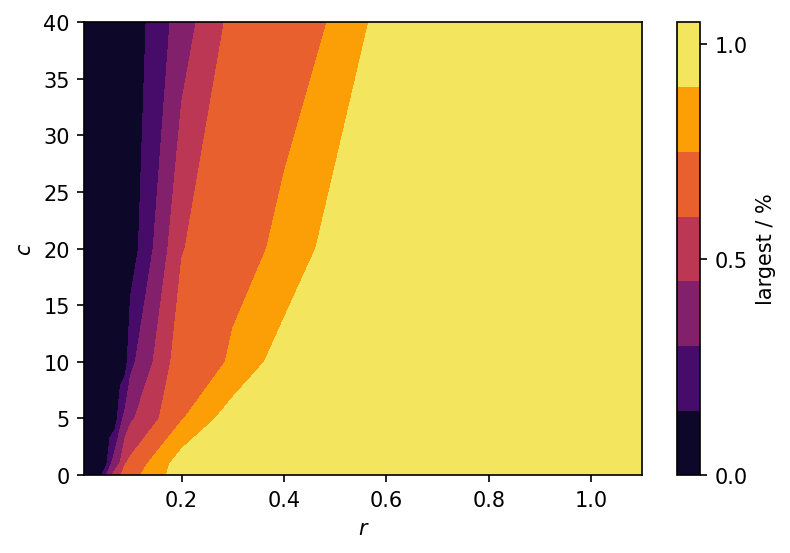

In [96]:
# Largest cluster
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="ratio_largest")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("largest / %")
ax.set_xlim(None, 1.1)

(0.01, 1.1)

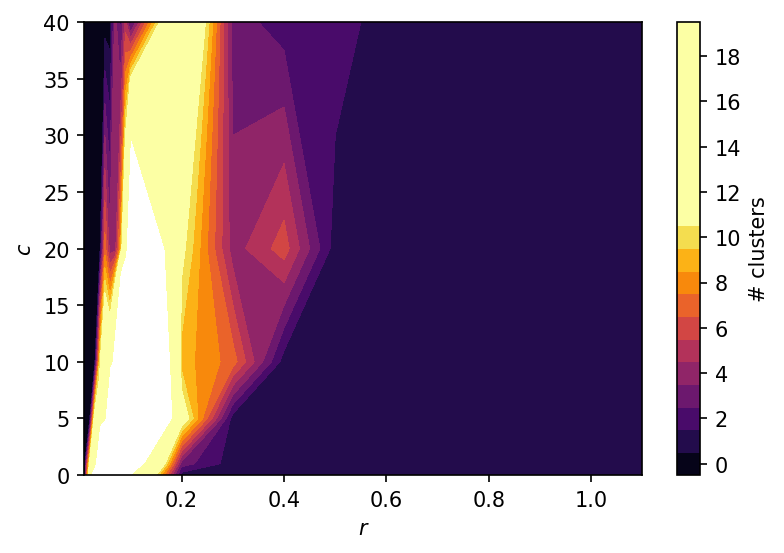

In [97]:
# Largest cluster
show_n = 20

fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="n_clusters", 
                                       contour_props={"levels": np.arange(-0.5, show_n, 1),
                                       "vmax": 11})[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=range(0, show_n + 1, 2))
colorbar.set_label("# clusters")
ax.set_xlim(None, 1.1)